# **Model Training and Evaluation**

In [7]:
!pip install scikit-optimize
!pip install xgboost
!pip install lightgbm

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Integer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)

This notebook loads the **feature-engineered datasets** created in the previous preprocessing pipeline.
These files include:
- `day_feature_engineered.csv`
- `hour_feature_engineered.csv`

They contain the **cleaned & transformed versions** of the raw `day.csv` and `hour.csv` datasets, prepared for model training.

**Location:** `Data_feature_engineered/`

In [10]:
dfd = pd.read_csv("/content/day_feature_engineered.csv")
dfh = pd.read_csv("/content/hour_feature_engineered.csv")

In [11]:
dfd.head()

,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [12]:
dfd.isnull().sum()

,0
season,0
mnth,0
holiday,0
weekday,0
workingday,0
weathersit,0
temp,0
atemp,0
hum,0
windspeed,0


In [13]:
dfh.head()

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,1,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,1,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [14]:
dfh.isnull().sum()

,0
season,0
mnth,0
hr,0
holiday,0
weekday,0
workingday,0
weathersit,0
temp,0
atemp,0
hum,0


**Function For Model Training And Evaluation**

In [15]:
def evaluate_models(df, label="Dataset"):
    """
    Evaluate multiple regression models using TRAINING + TESTING metrics.
    Returns:
    1. Performance table
    2. y_test
    3. Dictionary of test predictions for each model
    """

    X = df.drop("cnt", axis=1)
    y = df["cnt"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(alpha=1.0),
        "Lasso Regression": Lasso(alpha=0.001),
        "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5),
        "KNN Regressor": KNeighborsRegressor(n_neighbors=5),
        "SVR (RBF Kernel)": SVR(kernel="rbf", C=100, epsilon=0.1),
        "Random Forest": RandomForestRegressor(n_estimators=300, random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(random_state=42),
        "XGBoost": XGBRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            objective="reg:squarederror"
        ),
        "LightGBM": LGBMRegressor(
            n_estimators=500,
            learning_rate=0.05,
            num_leaves=64,
            max_depth=-1,
            subsample=0.8,
            colsample_bytree=0.8,
            force_col_wise=True,
            verbose=-1
        )
    }

    results = []
    predictions = {}

    for name, model in models.items():
        model.fit(X_train, y_train)

        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)

        predictions[name] = pred_test

        results.append([
            name,
            np.sqrt(mean_squared_error(y_train, pred_train)),
            np.sqrt(mean_squared_error(y_test, pred_test)),
            mean_absolute_error(y_train, pred_train),
            mean_absolute_error(y_test, pred_test),
            r2_score(y_train, pred_train),
            r2_score(y_test, pred_test)
        ])

    df_results = pd.DataFrame(
        results,
        columns=[
            "Model",
            "Train RMSE", "Test RMSE",
            "Train MAE", "Test MAE",
            "Train R²", "Test R²"
        ]
    )

    print(f"===== Detailed Performance Comparison: {label} =====")
    print(df_results)

    return df_results, y_test, predictions


In [16]:
import matplotlib.pyplot as plt
import math

def plot_all_models(y_test, preds_dict, title_prefix="Day Dataset", n_samples=200):
    models = list(preds_dict.keys())
    n_models = len(models)

    cols = 2
    rows = math.ceil(n_models / cols)

    # Take only first n samples
    y_plot = y_test.values[:n_samples]

    plt.figure(figsize=(14, rows * 3))

    for i, model in enumerate(models, 1):
        plt.subplot(rows, cols, i)
        plt.plot(y_plot, label="Actual", color="black", linewidth=2)
        plt.plot(preds_dict[model][:n_samples], label="Predicted", alpha=0.8)
        plt.title(model)
        plt.xlabel("Sample Index")
        plt.ylabel("cnt")
        plt.legend()

    plt.suptitle(
        f"Actual vs Predicted — {title_prefix} (First {n_samples} Samples)",
        fontsize=16
    )
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


#**Training Models on Daily Bike-Sharing Data(day.csv)**

**Evaluate Models**

In [17]:
results_day_df, y_day_test, preds_day = evaluate_models(dfd, "Day Dataset")


===== Detailed Performance Comparison: Day Dataset =====
               Model   Train RMSE    Test RMSE    Train MAE     Test MAE  Train R²   Test R²
0  Linear Regression  1341.968624  1270.864515  1133.379325  1075.671782  0.515175  0.571180
1   Ridge Regression  1344.395490  1277.916425  1140.406723  1086.244228  0.513420  0.566408
2   Lasso Regression  1341.968624  1270.866346  1133.380937  1075.674736  0.515175  0.571179
3         ElasticNet  1342.276402  1272.913486  1135.455905  1078.954567  0.514953  0.569796
4      KNN Regressor  1201.984255  1398.689505  1005.266318  1167.908333  0.611047  0.480580
5   SVR (RBF Kernel)  1577.151962  1547.148096  1291.927765  1301.889312  0.330351  0.364464
6      Random Forest   450.405270  1149.182779   382.966591   964.780648  0.945386  0.649366
7  Gradient Boosting   828.677709  1153.643821   707.441283   983.178799  0.815128  0.646638
8            XGBoost   178.728561  1212.809857   136.481415  1010.860901  0.991400  0.609463
9           L

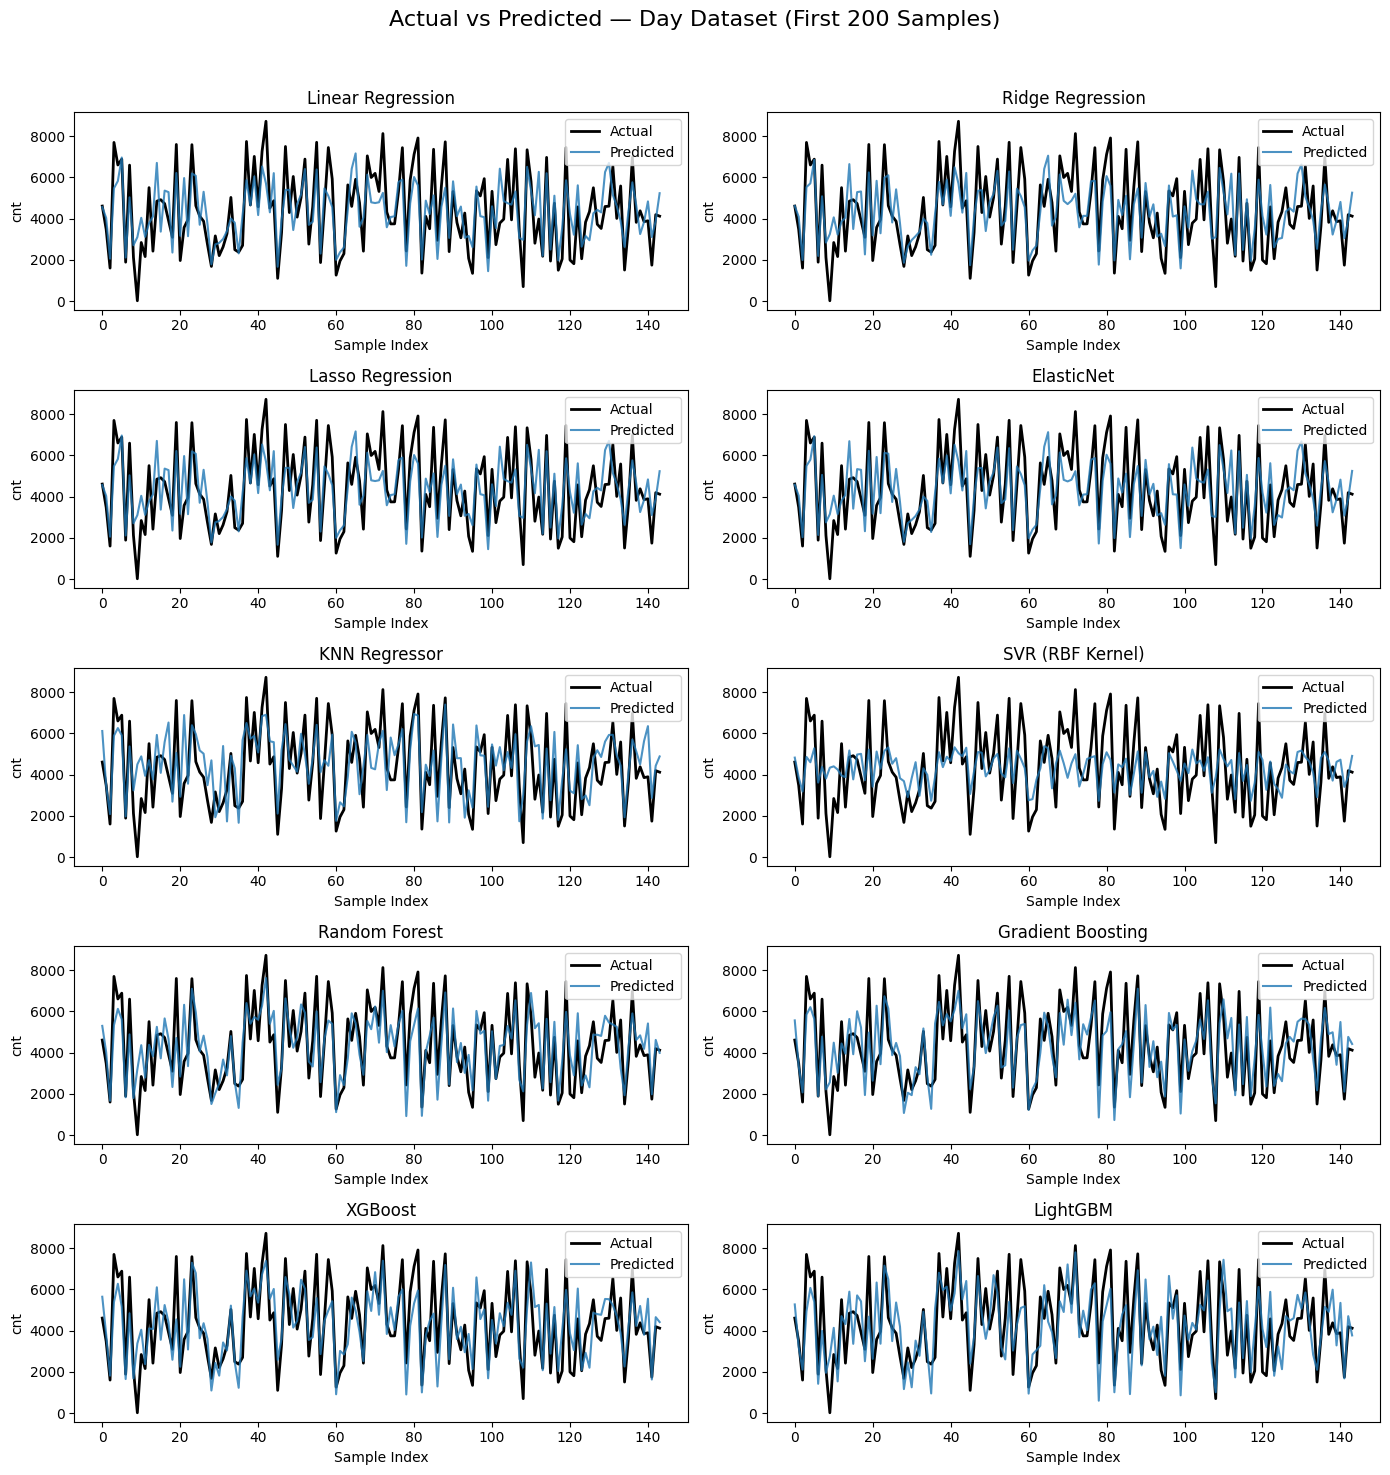

In [18]:
plot_all_models(y_day_test, preds_day, "Day Dataset", n_samples=200)

#**Training Models on Hourly Bike-Sharing Data(hour.csv)**

**Evaluate Models**

In [19]:
results_hour_df, y_hour_test, preds_hour = evaluate_models(dfh, "Hour Dataset")

===== Detailed Performance Comparison: Hour Dataset =====
               Model  Train RMSE   Test RMSE  Train MAE   Test MAE  Train R²   Test R²
0  Linear Regression  124.037631  125.369475  94.316521  95.037120  0.369425  0.345402
1   Ridge Regression  124.038518  125.368539  94.321185  95.047040  0.369416  0.345411
2   Lasso Regression  124.037633  125.368902  94.316718  95.037092  0.369425  0.345408
3         ElasticNet  124.049438  125.361959  94.346059  95.069962  0.369305  0.345480
4      KNN Regressor   55.803428   68.561895  37.603569  46.054672  0.872370  0.804225
5   SVR (RBF Kernel)  106.960393  109.163180  69.162520  69.596639  0.531105  0.503701
6      Random Forest   21.507735   56.992213  14.353142  37.943486  0.981041  0.864723
7  Gradient Boosting   71.853508   72.725253  50.729387  51.568180  0.788395  0.779727
8            XGBoost   46.642583   55.225253  32.264263  37.926872  0.910835  0.872982
9           LightGBM   35.161724   52.036587  24.354209  35.015756  0.94

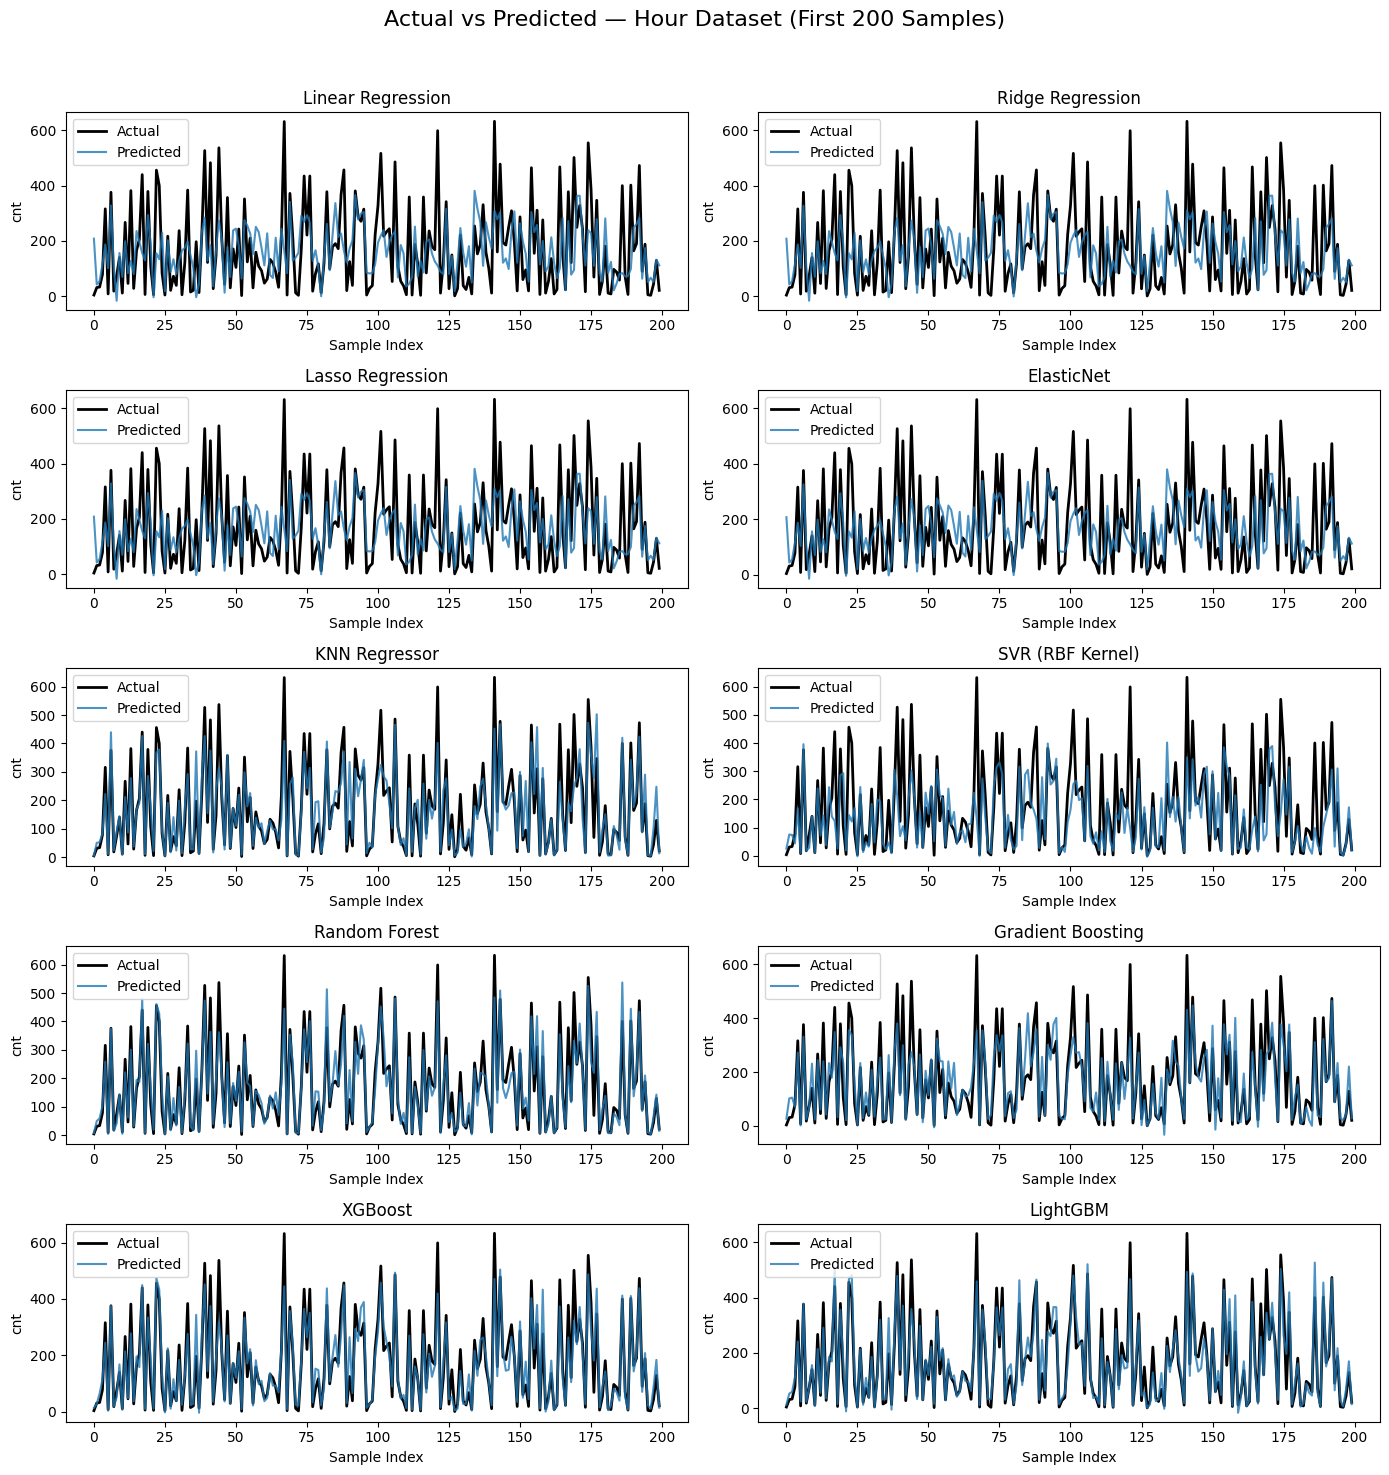

In [20]:
plot_all_models(y_hour_test, preds_hour, "Hour Dataset", n_samples=200)

#**Hyperparameter Tuning**

**Models**

In [21]:
models = {
    "Ridge": Ridge(),
    "Lasso": Lasso(max_iter=5000),
    "ElasticNet": ElasticNet(max_iter=5000),
    "KNN": KNeighborsRegressor(),
    "SVR": SVR(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(objective="reg:squarederror", random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(random_state=42, verbosity=-1)
}

**Grid Search**

In [22]:
grid_params = {
    "Ridge": {"alpha": [0.01, 0.1, 1, 10]},
    "Lasso": {"alpha": [0.001, 0.01, 0.1]},
    "ElasticNet": {"alpha": [0.01, 0.1], "l1_ratio": [0.3, 0.5, 0.7]},
    "KNN": {"n_neighbors": [3, 5, 7]},
    "SVR": {"C": [1, 10], "gamma": ["scale", "auto"]},
    "Random Forest": {"n_estimators": [200, 400], "max_depth": [None, 20]},
    "Gradient Boosting": {"n_estimators": [200, 400], "learning_rate": [0.05, 0.1]},
    "XGBoost": {"n_estimators": [200, 400], "max_depth": [4, 6]},
    "LightGBM": {"n_estimators": [200, 400], "num_leaves": [31, 63]}
}

**Randomized Search**

In [23]:
random_params = {
    "Ridge": {"alpha": np.logspace(-3, 2, 20)},
    "Lasso": {"alpha": np.logspace(-4, 1, 20)},
    "ElasticNet": {"alpha": np.logspace(-3, 1, 10), "l1_ratio": np.linspace(0.1, 0.9, 5)},
    "KNN": {"n_neighbors": range(3, 15)},
    "SVR": {"C": np.logspace(0, 3, 20)},
    "Random Forest": {"n_estimators": range(200, 800), "max_depth": range(5, 40)},
    "Gradient Boosting": {"n_estimators": range(200, 800), "learning_rate": np.linspace(0.01, 0.2, 10)},
    "XGBoost": {"n_estimators": range(200, 800), "max_depth": range(3, 10)},
    "LightGBM": {"n_estimators": range(200, 800), "num_leaves": range(20, 100)}
}

**Bayesian Optimization**

In [24]:
bayes_params = {
    "Ridge": {"alpha": Real(1e-3, 100)},
    "Lasso": {"alpha": Real(1e-4, 10)},
    "ElasticNet": {"alpha": Real(1e-3, 10), "l1_ratio": Real(0.1, 0.9)},
    "KNN": {"n_neighbors": Integer(3, 20)},
    "SVR": {"C": Real(0.1, 100)},
    "Random Forest": {"n_estimators": Integer(200, 800), "max_depth": Integer(5, 40)},
    "Gradient Boosting": {"n_estimators": Integer(200, 800), "learning_rate": Real(0.01, 0.2)},
    "XGBoost": {"n_estimators": Integer(200, 800), "max_depth": Integer(3, 10)},
    "LightGBM": {"n_estimators": Integer(200, 800), "num_leaves": Integer(20, 100)}
}

**Unified Evaluation Function**

In [25]:
def evaluate(model, X_train, X_test, y_train, y_test):
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    return {
        "Train RMSE": np.sqrt(mean_squared_error(y_train, pred_train)),
        "Test RMSE": np.sqrt(mean_squared_error(y_test, pred_test)),
        "Train MAE": mean_absolute_error(y_train, pred_train),
        "Test MAE": mean_absolute_error(y_test, pred_test),
        "Train R²": r2_score(y_train, pred_train),
        "Test R²": r2_score(y_test, pred_test),
    }


**Master Tuning Function**

In [26]:
def tune_all_models_with_methods(df, label="Dataset"):
    X = df.drop("cnt", axis=1)
    y = df["cnt"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    final_results = []
    best_models = {}

    for name, base_model in models.items():
        print(f"\n ****** {name} — {label} ******")

        tuning_strategies = []

        if name in grid_params:
            tuning_strategies.append((
                "Grid Search",
                GridSearchCV(base_model, grid_params[name], cv=3, scoring="r2", n_jobs=-1)
            ))

        if name in random_params:
            tuning_strategies.append((
                "Random Search",
                RandomizedSearchCV(
                    base_model,
                    random_params[name],
                    n_iter=15,
                    cv=3,
                    scoring="r2",
                    n_jobs=-1,
                    random_state=42
                )
            ))

        if name in bayes_params:
            tuning_strategies.append((
                "Bayesian Optimization",
                BayesSearchCV(
                    base_model,
                    bayes_params[name],
                    n_iter=20,
                    cv=3,
                    scoring="r2",
                    n_jobs=-1,
                    random_state=42
                )
            ))

        for method_name, search in tuning_strategies:
            search.fit(X_train, y_train)
            best_model = search.best_estimator_

            # Save trained model
            best_models[(name, method_name)] = best_model

            metrics = evaluate(best_model, X_train, X_test, y_train, y_test)

            final_results.append([
                name,
                method_name,
                metrics["Train RMSE"],
                metrics["Test RMSE"],
                metrics["Train MAE"],
                metrics["Test MAE"],
                metrics["Train R²"],
                metrics["Test R²"],
            ])

    results_df = pd.DataFrame(
        final_results,
        columns=[
            "Model", "Tuning Method",
            "Train RMSE", "Test RMSE",
            "Train MAE", "Test MAE",
            "Train R²", "Test R²"
        ]
    )

    return results_df, best_models


**FINAL TUNED RESULTS (DAY)**

In [27]:
day_results, day_best_models = tune_all_models_with_methods(dfd, "Day Dataset")
day_results


 ****** Ridge — Day Dataset ******

 ****** Lasso — Day Dataset ******

 ****** ElasticNet — Day Dataset ******

 ****** KNN — Day Dataset ******

 ****** SVR — Day Dataset ******

 ****** Random Forest — Day Dataset ******

 ****** Gradient Boosting — Day Dataset ******

 ****** XGBoost — Day Dataset ******

 ****** LightGBM — Day Dataset ******


,Model,Tuning Method,Train RMSE,Test RMSE,Train MAE,Test MAE,Train R²,Test R²
0,Ridge,Grid Search,1344.395490,1277.916425,1140.406723,1086.244228,0.513420,0.566408
1,Ridge,Random Search,1343.636897,1276.401326,1139.011417,1084.044452,0.513969,0.567435
2,Ridge,Bayesian Optimization,1342.434987,1273.448900,1135.990722,1079.805169,0.514838,0.569434
3,Lasso,Grid Search,1341.970372,1271.029238,1133.533035,1075.940922,0.515174,0.571069
4,Lasso,Random Search,1342.392997,1273.673568,1135.832418,1079.914330,0.514869,0.569282
5,Lasso,Bayesian Optimization,1342.237968,1273.044563,1135.303697,1078.981608,0.514981,0.569708
6,ElasticNet,Grid Search,1347.247449,1282.866078,1144.505813,1092.876065,0.511353,0.563043
7,ElasticNet,Random Search,1345.304181,1279.591332,1141.848874,1088.610399,0.512762,0.565271
8,ElasticNet,Bayesian Optimization,1342.811372,1274.507013,1137.106620,1081.374980,0.514566,0.568718
9,KNN,Grid Search,1201.984255,1398.689505,1005.266318,1167.908333,0.611047,0.480580


**FINAL TUNED RESULTS (HOUR)**

In [28]:
hour_results, hour_best_models = tune_all_models_with_methods(dfh, "Hour Dataset")
hour_results


 ****** Ridge — Hour Dataset ******

 ****** Lasso — Hour Dataset ******

 ****** ElasticNet — Hour Dataset ******

 ****** KNN — Hour Dataset ******

 ****** SVR — Hour Dataset ******

 ****** Random Forest — Hour Dataset ******

 ****** Gradient Boosting — Hour Dataset ******

 ****** XGBoost — Hour Dataset ******

 ****** LightGBM — Hour Dataset ******


,Model,Tuning Method,Train RMSE,Test RMSE,Train MAE,Test MAE,Train R²,Test R²
0,Ridge,Grid Search,124.038518,125.368539,94.321185,95.047040,0.369416,0.345411
1,Ridge,Random Search,124.041541,125.367171,94.328572,95.057736,0.369385,0.345426
2,Ridge,Bayesian Optimization,124.037777,125.369081,94.318220,95.041134,0.369423,0.345406
3,Lasso,Grid Search,124.037742,125.363582,94.318413,95.035355,0.369424,0.345463
4,Lasso,Random Search,124.037638,125.368293,94.316930,95.037061,0.369425,0.345414
5,Lasso,Bayesian Optimization,124.038945,125.348633,94.324003,95.029707,0.369411,0.345619
6,ElasticNet,Grid Search,124.129957,125.332648,94.487389,95.089848,0.368486,0.345786
7,ElasticNet,Random Search,124.044320,125.365405,94.334654,95.063246,0.369357,0.345444
8,ElasticNet,Bayesian Optimization,124.039098,125.367810,94.322896,95.049598,0.369410,0.345419
9,KNN,Grid Search,57.672298,66.438796,38.991489,45.054689,0.863678,0.816162


# **Prediction Strategy & Forecasting Logic**

- Overfit Gap = | R²_train − R²_test |

- Final Score = R²_test − λ × | R²_train − R²_test |

- λ - overfitting penalty

In [44]:
def get_best_model(results_df, best_models, overfit_penalty=0.5):
    """
    Selects best model based on:
    - High Test R²
    - Low Train–Test R² gap (generalization)
    - Production readiness
    """

    df = results_df.copy()

    # Overfitting gap
    df["Overfit_Gap"] = abs(df["Train R²"] - df["Test R²"])

    # Final production score
    df["Final_Score"] = df["Test R²"] - overfit_penalty * df["Overfit_Gap"]

    # Sort by final score
    best_row = df.sort_values("Final_Score", ascending=False).iloc[0]

    model_name = best_row["Model"]
    tuning_method = best_row["Tuning Method"]
    best_model = best_models[(model_name, tuning_method)]

    print("Model Selection Reasoning")
    print(f"Best Model      : {model_name}")
    print(f"Tuning Method   : {tuning_method}")
    print(f"Test R²         : {best_row['Test R²']:.4f}")
    print(f"Overfit Gap     : {best_row['Overfit_Gap']:.4f}")
    print(f"Final Score     : {best_row['Final_Score']:.4f}")

    return model_name, tuning_method, best_model


**Model Predictions Daily Bases**

In [30]:
def recursive_forecast_day(model, input_df, steps):
    preds = []
    current_input = input_df.copy()

    for i in range(steps):
        pred = model.predict(current_input)[0]
        preds.append(pred)

        # Example: increment month safely
        if "mnth" in current_input.columns:
            current_input["mnth"] = (current_input["mnth"] % 12) + 1

        # Rotate weekday
        if "weekday" in current_input.columns:
            current_input["weekday"] = (current_input["weekday"] + 1) % 7

    return preds


In [31]:
day_feature_cols = [
    "season", "mnth", "holiday", "weekday",
    "workingday", "weathersit", "temp",
    "atemp", "hum", "windspeed"
]


In [32]:
DAY_NAMES = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]

In [33]:
def predict_next_6_days(model, user_input, feature_cols):
    """
    Predict next 6 days with real weekday names, without index in output.
    """

    input_df = pd.DataFrame([user_input])[feature_cols]

    preds = recursive_forecast_day(
        model=model,
        input_df=input_df,
        steps=6
    )

    start_weekday = user_input["weekday"]  # 0=Sun, 6=Sat

    day_labels = [
        DAY_NAMES[(start_weekday + i) % 7] for i in range(0, 6)
    ]

    result_df = pd.DataFrame({
        "Day": day_labels,
        "Predicted cnt": np.round(preds, 2)
    })

    # Optional: remove index when printing or exporting
    result_df.index = [""] * len(result_df)

    return result_df


In [42]:
day_input = {
    "season": 1,
    "mnth": 1,
    "holiday": 0,
    "weekday": 2,
    "workingday": 1,
    "weathersit": 2,
    "temp": 0.344167,
    "atemp": 0.363625,
    "hum": 0.805833,
    "windspeed": 0.160446
}


In [45]:
model_name, tuning_method, best_day_model = get_best_model(
    day_results, day_best_models
)


print("\nDaily Forecast")
print(
    predict_next_6_days(
        best_day_model,
        day_input,
        day_feature_cols
    )
)

Model Selection Reasoning
Best Model      : Gradient Boosting
Tuning Method   : Bayesian Optimization
Test R²         : 0.6499
Overfit Gap     : 0.1070
Final Score     : 0.5964

Daily Forecast
  Day  Predicted cnt
  Tue        2506.80
  Wed        2605.12
  Thu        2605.12
  Fri        2639.28
  Sat        2660.23
  Sun        2498.83


**Model Predictions Hourly Bases**

In [36]:
hour_feature_cols = [
    "season", "mnth", "hr", "holiday", "weekday",
    "workingday", "weathersit", "temp",
    "atemp", "hum", "windspeed"
]

In [37]:
def recursive_forecast_hour(model, input_df, steps):
    preds = []
    current = input_df.copy()

    for _ in range(steps):
        pred = model.predict(current)[0]
        preds.append(pred)

        # increment hour safely
        current["hr"] = (current["hr"] + 1) % 24

        # update weekday if day rolls over
        if current["hr"].iloc[0] == 0:
            current["weekday"] = (current["weekday"] + 1) % 7

    return preds


In [38]:
def format_hour(hour):
    if hour == 0:
        return "12 AM"
    elif hour < 12:
        return f"{hour} AM"
    elif hour == 12:
        return "12 PM"
    else:
        return f"{hour - 12} PM"

In [39]:
def predict_next_6_hours(model, user_input, feature_cols):
    """
    Predict next 6 hours with real clock time labels, without index in output.
    """

    df = pd.DataFrame([user_input])[feature_cols]

    preds = recursive_forecast_hour(
        model=model,
        input_df=df,
        steps=6
    )

    start_hour = user_input["hr"]

    hour_labels = [
        format_hour((start_hour + i) % 24) for i in range(0, 6)
    ]

    result_df = pd.DataFrame({
        "Time": hour_labels,
        "Predicted cnt": np.round(preds, 2)
    })

    # Remove index for display
    result_df.index = [""] * len(result_df)

    return result_df


In [40]:
hour_input = {
    "season": 1,
    "mnth": 1,
    "hr": 10,
    "holiday": 0,
    "weekday": 2,
    "workingday": 1,
    "weathersit": 1,
    "temp": 0.24,
    "atemp": 0.2879,
    "hum": 0.81,
    "windspeed": 0.00
}


In [46]:
model_name, tuning_method, best_hour_model = get_best_model(
    hour_results, hour_best_models
)

print("\nHourly Forecast")
print(
    predict_next_6_hours(
        best_hour_model,
        hour_input,
        hour_feature_cols
    )
)


Model Selection Reasoning
Best Model      : LightGBM
Tuning Method   : Bayesian Optimization
Test R²         : 0.8892
Overfit Gap     : 0.0712
Final Score     : 0.8536

Hourly Forecast
   Time  Predicted cnt
  10 AM          78.43
  11 AM          69.66
  12 PM          81.14
   1 PM          64.53
   2 PM          45.44
   3 PM          55.70
